In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configuración de LaTeX para matplotlib
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],
    "font.sans-serif": ["DejaVu Sans"], # specify the sans-serif font
    "font.cursive": ["DejaVu Sans"],
    "font.monospace": [],
    "axes.labelsize": 8,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": (3.15, 2.17),     # default fig size of 0.9 textwidth
    "pgf.preamble": r' \usepackage{amsmath},\usepackage{cmbright},\usepackage[utf8x]{inputenc},\usepackage[T1]{fontenc},\usepackage{amssymb},\usepackage{amsfonts},\renewcommand{\familydefault}{\sfdefault}, \usepackage[cm]{sansmath},\sansmath',
        # plots will be generated using this preamble
    }
mpl.rcParams.update(pgf_with_latex)

 


Modelo con 1 neuronas entrenado.
Modelo con 2 neuronas entrenado.
Modelo con 3 neuronas entrenado.
Modelo con 4 neuronas entrenado.
Modelo con 5 neuronas entrenado.
Archivo 'approximations.csv' guardado con éxito.


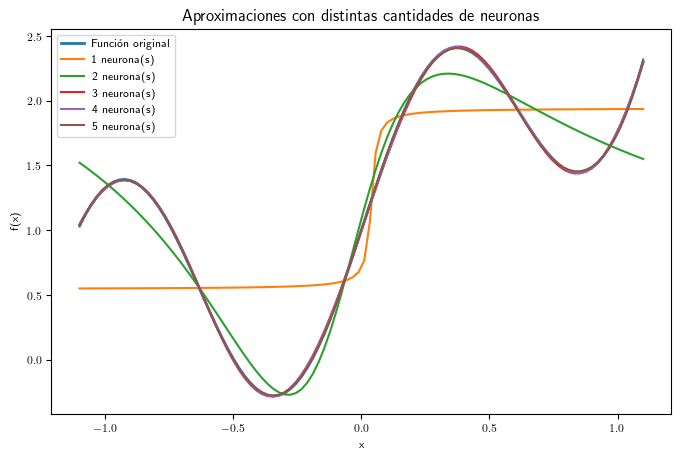

In [7]:
 

# ==== Datos de entrada (ejemplo genérico) ====
# Si ya tienes x y f definidos, omite esta parte
x = np.linspace(-1.1, 1.1, 100)
f = np.exp(x) + np.sin(5*x)
#f = x**3 - x**2 + x - 1

# Convertir datos a tensores
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
f_tensor = torch.tensor(f, dtype=torch.float32).unsqueeze(1)

# ==== Función para definir y entrenar la red ====
class SimpleNN(nn.Module):
    def __init__(self, hidden_neurons):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 1)

    def forward(self, x):
        x = torch.atan(self.fc1(x))
        x = self.fc2(x)
        return x

# ==== Entrenamiento para diferentes tamaños de red ====
results = []  # Para guardar las aproximaciones

for n_neurons in range(1, 6):  # de 1 a 5 neuronas
    model = SimpleNN(n_neurons)
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.01)

    def closure():
        optimizer.zero_grad()
        outputs = model(x_tensor)
        loss = criterion(outputs, f_tensor)
        loss.backward()
        return loss

    # Entrenar
    for epoch in range(500):  # menos épocas, suficiente para este ejemplo
        optimizer.step(closure)

    # Evaluar la red entrenada
    model.eval()
    x_vals = np.linspace(-1.1, 1.1, 100)
    with torch.no_grad():
        approx_vals = model(torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1)).numpy().flatten()

    # Guardar resultados en lista
    results.append(pd.DataFrame({
        "x": x_vals,
        f"approx_{n_neurons}_neurons": approx_vals
    }))

    print(f"Modelo con {n_neurons} neuronas entrenado.")

# ==== Combinar todos los resultados ====
df_combined = results[0]
for i in range(1, len(results)):
    df_combined = pd.merge(df_combined, results[i], on="x")

# Guardar también la función original para referencia
df_combined["original"] = np.interp(df_combined["x"], x, f)

# Exportar a CSV
df_combined.to_csv("approximations.csv", index=False)
print("Archivo 'approximations.csv' guardado con éxito.")

# ==== Graficar comparaciones ====
plt.figure(figsize=(8, 5))
plt.plot(x, f, label='Función original', linewidth=2)
for n in range(1, 6):
    plt.plot(df_combined["x"], df_combined[f"approx_{n}_neurons"], label=f'{n} neurona(s)')
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Aproximaciones con distintas cantidades de neuronas")
plt.show()


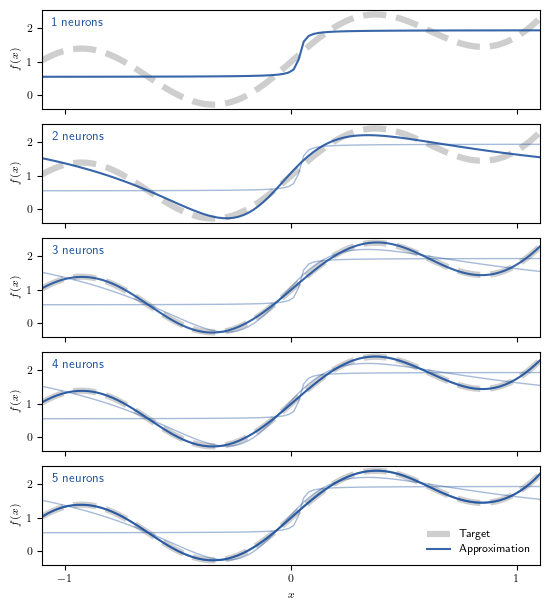

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Cargar los datos
df = pd.read_csv("approximations.csv")

# Configurar la figura
fig = plt.figure(figsize=(5.5, 6), constrained_layout=True)
gs = GridSpec(5, 1, figure=fig)
fig.set_constrained_layout_pads(w_pad=0.10, h_pad=0.05)

# Lista de las columnas de aproximaciones
approx_cols = [col for col in df.columns if "approx" in col]

# Crear los subplots
for i, col in enumerate(approx_cols):
    ax = fig.add_subplot(gs[i, 0])

    # Función original en negro
    orig_line, = ax.plot(df["x"], df["original"], '--', color="#CECECE", linewidth=4.5, label="Target")

    # Mostrar solo las aproximaciones anteriores en gris
    for prev_col in approx_cols[:i]:
        ax.plot(df["x"], df[prev_col], '-', color="#2255a080", alpha=0.4, linewidth=1.0)

    # Aproximación actual en azul semitransparente
    current_color = "#2255a080"  # azul semitransparente
    approx_line, = ax.plot(df["x"], df[col], color=current_color, linewidth=1.5, label=r"Approximation", alpha=0.9)

    # Extraer número de neuronas
    try:
        neurons = int(col.split('_')[-1])
    except ValueError:
        neurons = i + 1

    # Anotación con el mismo color que la línea actual
    ax.text(
        0.02, 0.93, f"{neurons} neurons",
        transform=ax.transAxes,
        fontsize=9,
        va='top', ha='left',
        color=current_color,
        alpha=1.0,
    )

    # Configurar ejes
    ax.set_xlim([df["x"].min(), df["x"].max()])
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1, 2])

    # Mostrar ticks solo en el último eje
    if i < len(approx_cols) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r"$x$")
        # Agregar leyenda solo en el último subplot
        ax.legend(
            handles=[orig_line, approx_line],
            loc='lower right',
            fontsize=8,
            frameon=False
        )

    ax.set_ylabel(r"$f(x)$")

# Guardar figuras
plt.savefig("universal_approximations.pdf", dpi=300, bbox_inches='tight')
plt.savefig("universal_approximations.svg", dpi=300, bbox_inches='tight')
plt.show()


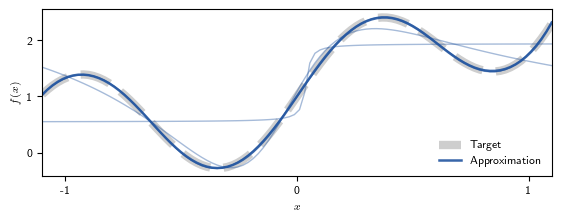

In [12]:
# Load data
df = pd.read_csv("approximations.csv")

# Identify approximation columns
approx_cols = [col for col in df.columns if "approx" in col]
last_col = approx_cols[-1]  # last approximation

# Create figure
fig, ax = plt.subplots(figsize=(5.5, 2.1), constrained_layout=True)

# Target function in light gray
ax.plot(df["x"], df["original"], '--', color="#CECECE", linewidth=6.0, label="Target")

# Previous approximations in gray
for prev_col in approx_cols[:-1]:
    ax.plot(df["x"], df[prev_col], '-', color="#2255a080", alpha=0.4, linewidth=1.0)

# Last approximation in blue
current_color = "#2255a0"
ax.plot(df["x"], df[last_col], color=current_color, linewidth=1.8, label="Approximation", alpha=0.9)

# Label with number of neurons
try:
    neurons = int(last_col.split('_')[-1])
except ValueError:
    neurons = len(approx_cols)
 

# Axes setup
ax.set_xlim([df["x"].min(), df["x"].max()])
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels([-1, 0, 1])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

# Legend
ax.legend(
    loc='lower right',
    fontsize=8,
    frameon=False
)

# Save and show
plt.savefig("universal_approximation.pdf", dpi=300, bbox_inches='tight')
plt.savefig("universal_approximation.svg", dpi=300, bbox_inches='tight')
# plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio

# Load data
df = pd.read_csv("approximations.csv")

# Make output folder
os.makedirs("frames_same_style", exist_ok=True)

# Columns with approximations
approx_cols = [col for col in df.columns if "approx" in col]

# --- Generate one figure per approximation ---
for i, col in enumerate(approx_cols):
    fig, ax = plt.subplots(figsize=(5.5, 3))

    # Original function (gray dashed)
    orig_line, = ax.plot(df["x"], df["original"], '--', color="#CECECE", linewidth=4.5, label="Original")

    # Previous approximations in gray (optional)
    for prev_col in approx_cols[:i]:
        ax.plot(df["x"], df[prev_col], '-', color="#2255a080", alpha=0.4, linewidth=1.0)

    # Current approximation (blue)
    current_color = "#2255a080"
    approx_line, = ax.plot(df["x"], df[col], color=current_color, linewidth=1.5,
                           label=r"Approximation", alpha=0.9)

    # Extract neuron count
    try:
        neurons = int(col.split('_')[-1])
    except ValueError:
        neurons = i + 1

    # Annotation (same color)
    ax.text(
        0.02, 0.93, f"{neurons} neurons",
        transform=ax.transAxes,
        fontsize=9,
        va='top', ha='left',
        color=current_color,
        alpha=1.0,
    )

    # --- Match exact axis/tick format ---
    ax.set_xlim([df["x"].min(), df["x"].max()])
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1, 2])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")

    # Legend like your last subplot
    ax.legend(
        handles=[orig_line, approx_line],
        loc='lower right',
        fontsize=8,
        frameon=False
    )

    # Tight layout
    plt.tight_layout()

    # Save frame
    plt.savefig(f"frames_same_style/frame_{i:02d}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

print("✅ Frames saved in folder 'frames_same_style/'")

# --- Create GIF animation ---
frames = [imageio.imread(f"frames_same_style/frame_{i:02d}.png") for i in range(len(approx_cols))]
imageio.mimsave("universal_approximation_same_style.gif", frames, duration=1.2)

print("🎬 Animation saved as universal_approximation_same_style.gif")


ModuleNotFoundError: No module named 'imageio'

In [ ]:
import imageio.v2 as imageio

frames = [imageio.imread(f"frames_same_style/frame_{i:02d}.png") for i in range(len(approx_cols))]

# Very slow: 0.2 frames per second (each frame = 5 seconds)
imageio.mimsave("universal_approximation_single.gif", frames, fps=0.5)

print("🎬 Saved slow animation (≈5 s per frame, fps=0.5)")



🎬 Saved slow animation (≈5 s per frame, fps=0.5)
